In [10]:
import nest
import matplotlib.pyplot as plt

import sim_ballena as ballena
import time
import numpy as np

In [ ]:
def spike_generator(max_time, dt, n_spikes, ch=0):
	assert n_spikes<((max_time/dt)-1), "No puede haber mas spikes que timesteps"
	prob = n_spikes/((max_time/dt)-1)

	spikes = []
	t = dt
	while t<max_time:
		if np.random.random()<prob:
			spikes.append((t,ch))
		t = round(t+dt, 6)
	return spikes

In [13]:
# ======================
#  SIMULATE NEST PLOT
# ======================
def simulate_nest_voltages(inputs, w_in, w_net, tau=[10,10], refrac=2, max_time=20):
	input_t,_ = zip(*inputs)
	nest.ResetKernel()
	nest.set_verbosity("M_FATAL")
	nest.resolution = 0.01

	# ===============
	# CREATE OBJECTS
	I = nest.Create("spike_generator", params={"spike_times": input_t})

	N0 = nest.Create('iaf_psc_delta', params={'V_m': -70,'V_th': -55,'tau_m': tau[0],'t_ref': refrac,'V_reset': -70})
	N1 = nest.Create('iaf_psc_delta', params={'V_m': -70,'V_th': -55,'tau_m': tau[1],'t_ref': 0     ,'V_reset': -70})

	multimeter = nest.Create("multimeter")
	multimeter.interval = 0.01
	multimeter.set(record_from=["V_m"])
	
	nest.Connect(I, N0, syn_spec={"weight":w_in, "delay":0.01})
	nest.Connect(N0, N1, syn_spec={"weight":w_net, "delay":0.01})
	nest.Connect(multimeter, N0)
	nest.Connect(multimeter, N1)

	# ===============
	#  RUN AND PLOT
	nest.Simulate(max_time)

	v0 = multimeter.get('events')['V_m'][::2]
	v1 = multimeter.get('events')['V_m'][1::2]
	t0    = multimeter.get('events')['times'][::2]
	t1    = multimeter.get('events')['times'][1::2]
	plt.plot( t0, v0, label='nest neu0')
	plt.plot( t1, v1, label='nest neu1')

# =======================
#  SIMULATE BALLENA PLOT
# =======================
def simulate_ballena_voltages(inputs,w_in,w_net,tau=[10,10], refrac=2,max_time=20):
	instance = ballena.Instance(inputs)

	n = [ballena.Lif().tau(tau[0]).t_refractory(refrac),
	  	 ballena.Lif().tau(tau[1]).t_refractory(0)]

	net = (ballena.Network(n)
			.synapses_in([(0,0)])
			.synapses_net([(0,1)])
			.weights_in([w_in])
			.weights_net([w_net])
			.outputs([0,1])
			.mode(['VOLTAGES']))
	res = net.simulate( instance, max_time ).set_resolution(0.001)
	time = res.time()
	volt = res.voltages()

	plt.plot( time, volt[0], label='Ballena neu0' )
	plt.plot( time, volt[1], label='Ballena neu1' )


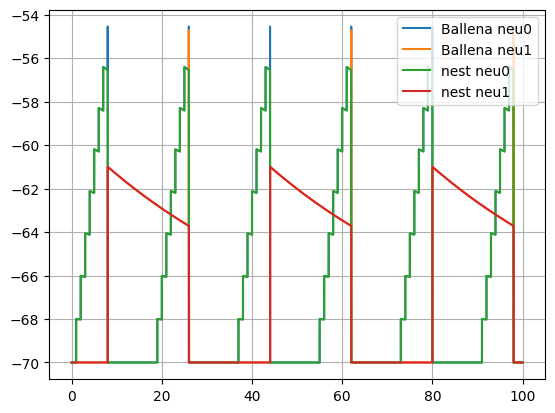

In [14]:
inputs = [(t,0) for t in range(1,100,1)]

simulate_ballena_voltages(inputs,w_in=2, w_net=9, tau=[100,50], refrac=10, max_time=100)
simulate_nest_voltages(inputs, w_in=2, w_net=9, tau=[100,50], refrac=10, max_time=100)
plt.legend()
plt.grid()
plt.show()


In [15]:
# ========================
#  SIMULATE NEST VELOCITY
# ========================
def simulate_nest_fast(inputs, w, tau=10, max_time=20, epochs=100):
    input_t,_ = zip(*inputs)
    
    # MUEVE LA CONFIGURACIÓN FUERA DEL LOOP
    nest.ResetKernel()
    nest.set_verbosity("M_FATAL")
    nest.resolution = 0.01
    
    # CREA OBJETOS UNA SOLA VEZ
    I = nest.Create("spike_generator", params={"spike_times": input_t})
    N1 = nest.Create('iaf_psc_delta', params={'V_m': -70,'V_th': -55,'tau_m': tau,'t_ref': 0,'V_reset': -70})
    N2 = nest.Create('iaf_psc_delta', params={'V_m': -70,'V_th': -55,'tau_m': tau,'t_ref': 0,'V_reset': -70})
    N3 = nest.Create('iaf_psc_delta', params={'V_m': -70,'V_th': -55,'tau_m': tau,'t_ref': 0,'V_reset': -70})
    
    nest.Connect(I, N1, syn_spec={"weight":w, "delay":0.1})
    nest.Connect(I, N2, syn_spec={"weight":w, "delay":0.1})
    nest.Connect(I, N3, syn_spec={"weight":w, "delay":0.1})
    
    # SOLO SIMULA EN EL LOOP
    start = time.time()
    for _ in range(epochs):
        nest.SetStatus(N1, {"V_m": -70})  # Resetear estado
        nest.SetStatus(N2, {"V_m": -70})  # Resetear estado
        nest.SetStatus(N3, {"V_m": -70})  # Resetear estado
        nest.Simulate(max_time)
    return time.time()-start

# ===========================
#  SIMULATE BALLENA VELOCITY
# ===========================
def simulate_ballena_fast(inputs,w,tau=10,max_time=20, epochs=100):
	instance = ballena.Instance(inputs)

	n = ballena.Lif().tau(tau).repeat(3)
	net = (ballena.Network(n)
			.synapses_in([(0,0),(0,1),(0,2)])
			.synapses_net([])
			.weights_in([w]*3)
			.weights_net([])
			.outputs([0]))
	start = time.time()
	for _ in range(epochs):
		res = net.simulate( instance, max_time )

	return time.time()-start


In [21]:
inputs = spike_generator(100,0.01,100)
inputs = ballena.Instance( inputs )
inputs

In [ ]:
inputs = spike_generator(100,0.01,100)

t_ballena = simulate_ballena_fast(inputs, w=4, tau=4, max_time=100, epochs=5000)
t_nest    = simulate_nest_fast(inputs, w=4, tau=4, max_time=100, epochs=5000)

print('t_ballena', t_ballena)
print('t_nest', t_nest)
print(f'ballena es {t_nest/t_ballena} veces mas rapido')

t_ballena 0.7835497856140137
t_nest 7.289111375808716
ballena es 9.302678029701386 veces mas rapido
